In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.api import OLS

### Чтение данных

In [2]:
import pickle
# v_fact=pickle.load(open('2d_advection_fact.pkl','rb'))
# v_fact=pickle.load(open('2d_advection_fact_2var.pkl','rb'))

path=fr'D:\myProjects\diplom_2\GIT_stencil-net\Experiments\Experiment_2d_advection/'
v_fact=pickle.load(open(path+'data.pkl','rb'))

In [3]:
h=0.05
tau=0.05
# tau=0.025
# tau=0.1

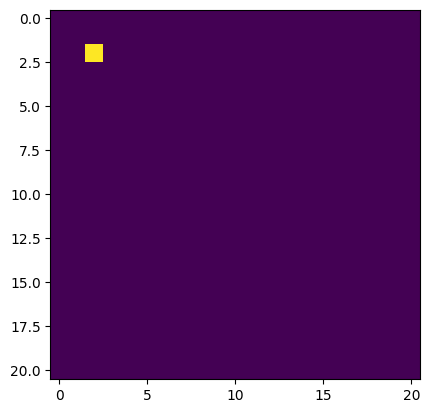

In [4]:
plt.imshow(v_fact[0,:,:])

In [5]:
v_fact.shape

(18, 21, 21)

### Линеаризация

In [6]:
def linearization(v_fact):

    n=len(v_fact)
    A=np.zeros((n*n))

    for i in range(n):
        for j in range(n):
            A[i+n*j]=v_fact[i,j]

    return A

def get_value(A,i,j):

    n=int(np.sqrt(len(A)))
    
    if i>=n and j>=n:
        value = A[i-n+n*j-n]
    elif i>=n:
        value = A[i-n+n*j]
    elif j>=n:
        value = A[i+(n*j)-n]
    else:
        value = A[i+n*j]

    return value

def get_value(A, i, j):
    # Handle periodic boundary conditions
    n=int(np.sqrt(len(A)))
    i = i % n  # Wrap around if i is outside [0, n-1]
    j = j % n  # Wrap around if j is outside [0, n-1]
    return A[i + n * j]

In [7]:
def linearization_inverse(v_fact):

    n=int(np.sqrt(len(v_fact)))
    v_fact_mat=np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            v_fact_mat[i,j]=get_value(v_fact,i,j)


    return v_fact_mat

In [8]:
### test
test_matrix=np.zeros((5,5))
for i in range(5):
    for j in range(5):
        if i==0 or j==0 or i==4 or j==4:
            test_matrix[i,j]=-999
            # test_matrix[i,j]=i+j*4
        else:
            test_matrix[i,j]=i+j*4

test_output=linearization(test_matrix)

for i in range(5):
    for j in range(5):
        assert test_matrix[i,j]==get_value(test_output,i,j),fr'{i},{j} не совпадает'


In [9]:
test_matrix

array([[-999., -999., -999., -999., -999.],
       [-999.,    5.,    9.,   13., -999.],
       [-999.,    6.,   10.,   14., -999.],
       [-999.,    7.,   11.,   15., -999.],
       [-999., -999., -999., -999., -999.]])

In [10]:
test_output

array([-999., -999., -999., -999., -999., -999.,    5.,    6.,    7.,
       -999., -999.,    9.,   10.,   11., -999., -999.,   13.,   14.,
         15., -999., -999., -999., -999., -999., -999.])

In [11]:
linearization_inverse(test_output)

array([[-999., -999., -999., -999., -999.],
       [-999.,    5.,    9.,   13., -999.],
       [-999.,    6.,   10.,   14., -999.],
       [-999.,    7.,   11.,   15., -999.],
       [-999., -999., -999., -999., -999.]])

In [12]:
get_value(test_output,4,4)

np.float64(-999.0)

In [13]:
# #ниже определяю функцию
# A=make_A(test_output,5)
# A.shape

In [14]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=4, include_bias=True)
# X_poly = poly.fit_transform(A)
# X_poly.shape

In [15]:
# drop_boundary_points(A)

In [16]:
# filtered_arr = np.delete(A, drop_boundary_points(A), axis=0)  # axis=0 — удаляем строки
# filtered_arr

In [17]:
# B_mat=make_B(test_output,5)
# B_mat = poly.fit_transform(B_mat)
# B_mat.shape

In [18]:
# np.concatenate([A,B_mat],axis=1).shape

### ПреПроцесс конечно-разн аналогии

In [19]:
# [-1.00000000e+03, -5.49116308e-13,  8.16013923e-13, -1.79700699e-12,
#        -2.90700797e-12, -8.81072992e-13,  1.00000000e+03])

#     if self.fs % 2 != 0:
#             n = int(np.sqrt(x.shape[1]))
#             px = self.make_px(x, 0, 0, n)
#             for i in range(1, int(self.fs/2)+1):
#                 l = self.make_px(x, -i, 0, n)
#                 r = self.make_px(x, i, 0, n)
#                 l2 = self.make_px(x, 0, -i, n)
#                 r2 = self.make_px(x, 0, i, n)
#                 rl = self.make_px(x, i, i, n)
#                 rl2 = self.make_px(x, -i, -i, n)
#                 px = torch.cat([l, l2, px, r, r2,rl,rl2], -1)

In [20]:
def make_A(u_0,n):

    # n2=5
    n2=9

    A=np.zeros((n*n,n2))
    # conv coeffs
    for i in range(0,n):
        for j in range(0,n):
            ind=i+j*(n)
            
            # Величины 1-й степени
            A[ind][0]=get_value(u_0,i,j)
            A[ind][1]=get_value(u_0,i,j-1)
            A[ind][2]=get_value(u_0,i,j+1)
            A[ind][3]=get_value(u_0,i-1,j)
            A[ind][4]=get_value(u_0,i+1,j)

            A[ind][5]=get_value(u_0,i,j-2)
            A[ind][6]=get_value(u_0,i-2,j)
            A[ind][7]=get_value(u_0,i,j+2)
            A[ind][8]=get_value(u_0,i+2,j)

    return A

def make_B(u_0,n):

    # n2=2
    n2=4

    A=np.zeros((n*n,n2))
    # conv coeffs
    for i in range(0,n):
        for j in range(0,n):
            ind=i+j*(n)
            
            # Величины 1-й степени
            A[ind][0]=get_value(u_0,i+1,j+1)
            A[ind][1]=get_value(u_0,i-1,j-1)

            A[ind][0]=get_value(u_0,i+2,j+2)
            A[ind][2]=get_value(u_0,i-2,j-2)

    return A

def drop_boundary_points(A_mat):

    A=A_mat.copy()

    n=int(np.sqrt(len(A)))
    
    boundary_id=[i+j*n for i in range(n) for j in range(n) if i==0 or j==0 or i==n-1 or j==n-1]

    return sorted(boundary_id)

def make_rhs(t_0,t_1,n,tau):
    
    rhs=np.zeros((n*n,1))
    
    for i in range(0,n):
        for j in range(0,n):
            rhs[i+j*n][0]=(get_value(t_1,i,j)-get_value(t_0,i,j))/tau

    return rhs

### Конечно-разн аналогия

In [21]:
v_fact.shape[0]

18

In [22]:
# n_cycle = v_fact.shape[0]-1
# n_cycle=100
# n_cycle=17
n_cycle=8

coeffs_lst=[]
mse_lst=[]
for j in range(n_cycle):
    
    u_0=v_fact[j,:,:]
    u_1=v_fact[j+1,:,:]
    n=21

    u_0=linearization(u_0) # начальное состояние
    u_1=linearization(u_1) # следующее состояние

    A_mat=make_A(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=True)
    # A_mat = poly.fit_transform(A_mat)

    B_mat=make_B(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=False)
    # B_mat = poly.fit_transform(B_mat)

    A_mat=np.concatenate([A_mat,B_mat],axis=1)

    rhs=make_rhs(u_0,u_1,n,tau=tau)

    print(A_mat.shape,rhs.shape)

    S = A_mat
    rhs = rhs
    S=np.delete(A_mat, drop_boundary_points(A_mat), axis=0) 
    rhs=np.delete(rhs,drop_boundary_points(rhs), axis=0)

    print(S.shape,rhs.shape)
    
    model_sm=OLS(rhs,S,hasconst=True)
    results_sm=model_sm.fit()
    
    mse=mean_squared_error(rhs,results_sm.predict(S))
    # print("MSE :",mse)
    
    # print('COEFFICIENT',results_sm.params)
    mse_lst.append(mse)
    coeffs_lst.append(results_sm.params)
    
mse_lst=np.array(mse_lst)
coeffs_lst=np.array(coeffs_lst)

(441, 13) (441, 1)
(361, 13) (361, 1)
(441, 13) (441, 1)
(361, 13) (361, 1)
(441, 13) (441, 1)
(361, 13) (361, 1)
(441, 13) (441, 1)
(361, 13) (361, 1)
(441, 13) (441, 1)
(361, 13) (361, 1)
(441, 13) (441, 1)
(361, 13) (361, 1)
(441, 13) (441, 1)
(361, 13) (361, 1)
(441, 13) (441, 1)
(361, 13) (361, 1)


In [23]:
results_sm.summary()

C:\Users\tyxba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\tyxba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1871: RuntimeWarning: divide by zero encountered in scalar divide
  return self.mse_model/self.mse_resid
C:\Users\tyxba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\tyxba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-pac

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        16:31:13   Log-Likelihood:                    inf
No. Observations:                 361   AIC:                              -inf
Df Residuals:                     349   BIC:                              -inf
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -20.0000          0       -inf      0.000     -20.000     -20.000
x2                  0          0        nan        nan           0           0
x3                  0          0        nan        nan           0           0
x4                  0          0        nan        nan           0           0
x5                  0          0        nan        nan           0           0
x6                  0          0        nan        nan           0           0
x7                  0          0        nan        nan           0           0
x8                  0          0        nan        nan           0           0
x9                  0          0        nan        nan           0           0
x10                 0          0        nan        nan           0           0
x11           20.0000          0        inf      0.000      20.000      20.000
x12                 0          0        nan        nan           0           0
const               0          0        nan        nan           0           0
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
coeffs_lst[-1]

array([-20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.,
         0.,   0.])

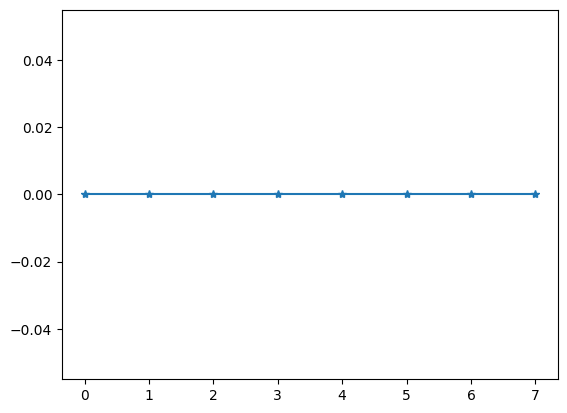

In [25]:
plt.plot(mse_lst,'-*')
# plt.ylim([-1,1])

In [26]:
A_mat.shape,B_mat.shape

((441, 13), (441, 4))

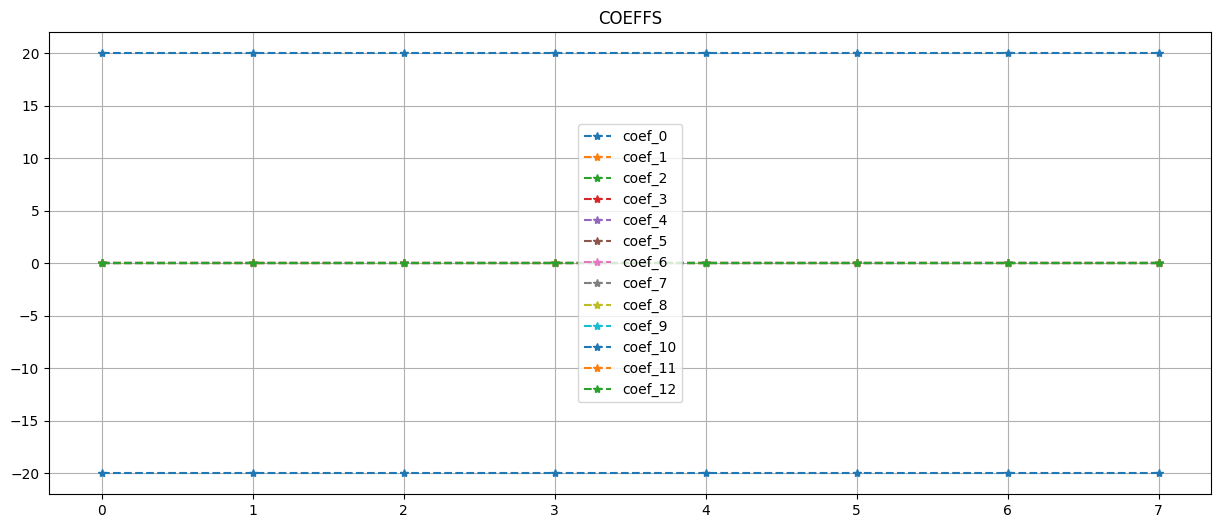

In [27]:
plt.figure(figsize=(15,6))
for j in range(len(coeffs_lst[0,:])):
    plt.plot(coeffs_lst[:,j],'--*',label=fr'coef_{j}')
# plt.ylim([-2000,2000])
plt.title('COEFFS')
plt.legend()
plt.grid()

In [28]:
coeffs_lst[-1]

array([-20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  20.,
         0.,   0.])

In [29]:
1/2/h

10.0

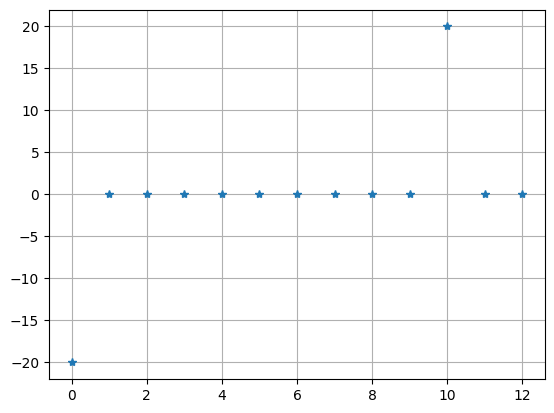

In [30]:
plt.plot(pd.Series(coeffs_lst[-1]).sort_values(),'*')
plt.grid()

In [31]:
len(coeffs_lst)

8

0 1


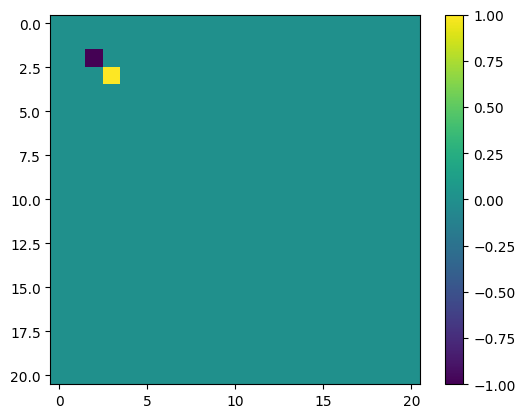

-----------------TIME INDEX = 0----------------
[-20.   0.   0.   0.   0.   0.   0.   0.   0.   0.  20.   0.   0.]


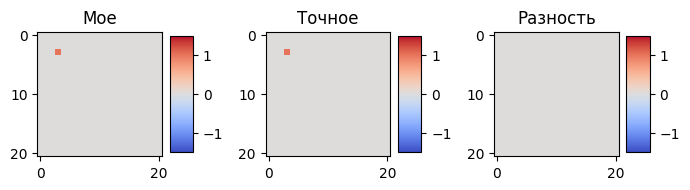

5 6


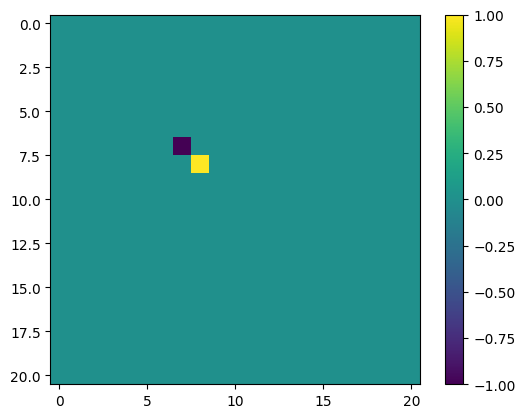

-----------------TIME INDEX = 5----------------
[-20.   0.   0.   0.   0.   0.   0.   0.   0.   0.  20.   0.   0.]


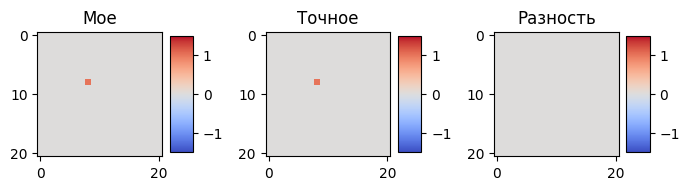

In [32]:
for j in range(0,n_cycle,5):
    
    print(j,j+1)
    u_0=v_fact[j,:,:]
    u_1=v_fact[j+1,:,:]
    n=21
    
    plt.imshow(u_1-u_0)
    plt.colorbar()
    plt.show()

    u_0=linearization(u_0) # начальное состояние
    u_1=linearization(u_1) # следующее состояние


    A_mat=make_A(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=True)
    # A_mat = poly.fit_transform(A_mat)

    B_mat=make_B(u_0,n)
    # poly = PolynomialFeatures(degree=2, include_bias=False)
    # B_mat = poly.fit_transform(B_mat)

    A_mat=np.concatenate([A_mat,B_mat],axis=1)
    
    rhs=make_rhs(u_0,u_1,n,tau=tau)

    print(fr'-----------------TIME INDEX = {j}----------------')
    # print(A_mat.shape,rhs.shape)

    S = A_mat
    rhs = rhs

    print(coeffs_lst[-3])
    logit_sol=np.dot(S,coeffs_lst[-3])*tau
    logit_sol[drop_boundary_points(logit_sol)]=0

    vmin=-1.5
    vmax=1.5

    plt.figure(figsize=(7, 2))
    plt.subplot(1,3,1)
    img1=plt.imshow(linearization_inverse(logit_sol+u_0),vmin=vmin,vmax=vmax,
               label='logit_sol',
               cmap='coolwarm')
    plt.title('Мое')
    cbar=plt.colorbar(img1,aspect=5)

    plt.subplot(1,3,2)
    img2=plt.imshow(linearization_inverse(u_1),vmin=vmin,vmax=vmax,
               label='logit_sol',
               cmap='coolwarm')
    plt.title('Точное')
    plt.colorbar(img2,aspect=5)

    plt.subplot(1,3,3)
    img3=plt.imshow(linearization_inverse(u_1)-linearization_inverse(logit_sol+u_0),
                    vmin=-1.5,vmax=1.5,
               label='logit_sol',
               cmap='coolwarm')
    plt.title('Разность')
    plt.colorbar(img3,aspect=5)

    plt.tight_layout()  # Чтобы избежать наложения подписей

    # plt.savefig(fr'')

    plt.show()

In [33]:
h,tau,1/h,-1/h

(0.05, 0.05, 20.0, -20.0)

In [34]:
len(drop_boundary_points(logit_sol))

80

In [35]:
v_fact.shape,21*21

((18, 21, 21), 441)

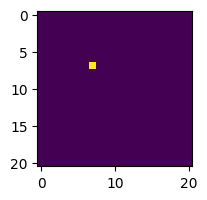

In [36]:
plt.figure(figsize=(2,3))
plt.imshow(linearization_inverse(u_0))

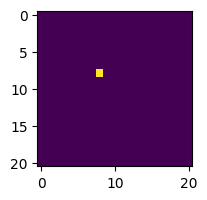

In [37]:
plt.figure(figsize=(2,3))
plt.imshow(linearization_inverse(np.dot(S,coeffs_lst[-3])*tau+u_0))

In [38]:
linearization_inverse(u_0)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

In [39]:
linearization_inverse(np.dot(S,coeffs_lst[-3])*tau+u_0)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,